In [25]:
import requests
import pandas as pd
import numpy as np
import sklearn

In [26]:
import sklearn
print(sklearn.__version__)

1.6.1


In [27]:
def fetch_nasa_hourly_data(latitude, longitude, start_year, end_year):
    """Fetch hourly solar and weather data from NASA POWER API for multiple parameters and merge them year by year."""
    
    parameters = ["ALLSKY_SFC_SW_DWN", "T2M", "WS2M", "RH2M", "PRECTOTCORR",'CLOUD_AMT' ]
    base_url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    
    df_final = None  # Initialize final DataFrame

    # Loop through years to fetch data in smaller chunks
    for year in range(start_year, end_year + 1):
        dfs = []  # Store DataFrames for each parameter

        for param in parameters:
            url = f"{base_url}?parameters={param}&community=RE&longitude={longitude}&latitude={latitude}&start={year}0101&end={year}1231&format=JSON"
            response = requests.get(url)
            response.raise_for_status()  # Check for errors from API endpoint
            
            data = response.json()
            param_data = data['properties']['parameter'].get(param, {})

            # Convert to DataFrame
            df = pd.DataFrame(list(param_data.items()), columns=['timestamp', param])
            df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y%m%d%H")
            dfs.append(df)

        # Merge all parameters for the given year
        df_year = dfs[0]
        for df in dfs[1:]:
            df_year = df_year.merge(df, on='timestamp', how='outer')

        # Append to final DataFrame
        df_final = df_year if df_final is None else pd.concat([df_final, df_year])

    # Sort by timestamp
    df_final = df_final.sort_values('timestamp').reset_index(drop=True)

    # Extract year, month, day, hour for filtering
    df_final['year'] = df_final['timestamp'].dt.year
    df_final['month'] = df_final['timestamp'].dt.month
    df_final['day'] = df_final['timestamp'].dt.day
    df_final['hour'] = df_final['timestamp'].dt.hour

    return df_final

# Example usage
latitude, longitude = 37.7749, -122.4194  # San Francisco coordinates
df_hourly = fetch_nasa_hourly_data(latitude, longitude, start_year=2010,end_year=2021)

# Display first few rows
print(df_hourly.head())


            timestamp  ALLSKY_SFC_SW_DWN    T2M  WS2M   RH2M  PRECTOTCORR  \
0 2010-01-01 00:00:00                0.0  10.14  1.93  91.97         0.43   
1 2010-01-01 01:00:00                0.0  10.24  1.94  91.59         0.61   
2 2010-01-01 02:00:00                0.0  10.27  1.92  91.26         0.78   
3 2010-01-01 03:00:00                0.0  10.25  1.90  91.21         0.84   
4 2010-01-01 04:00:00                0.0  10.06  1.83  92.21         1.54   

   CLOUD_AMT  year  month  day  hour  
0      100.0  2010      1    1     0  
1      100.0  2010      1    1     1  
2      100.0  2010      1    1     2  
3      100.0  2010      1    1     3  
4      100.0  2010      1    1     4  


In [28]:
#apply time series regression. 
#convert the features into meaning full data line hours need to be converted into sine/cosine so that the model understands the differnece between hours

# for hourly variation
df_hourly['hour_sin']=np.sin(2*np.pi*df_hourly['hour']/24)
df_hourly['hour_cos']=np.cos(2*np.pi*df_hourly['hour']/24)

#for daily variation
#convert day of the year to sine cosine to capture 
df_hourly['day_of_year_sin']= np.sin(2*np.pi*df_hourly['day']/365)
df_hourly['day_of_year_cos']= np.sin(2*np.pi*df_hourly['day']/365)

# since linear regression dosent capture the past data effectively its important to introduce lag features into the model 

df_hourly['lag1']= df_hourly['ALLSKY_SFC_SW_DWN'].shift(1)
df_hourly['lag24']= df_hourly['ALLSKY_SFC_SW_DWN'].shift(24)
df_hourly['lag365']= df_hourly['ALLSKY_SFC_SW_DWN'].shift(8760)

df_hourly.dropna(inplace=True)

df_hourly.drop(['year','month','day','hour','timestamp'],inplace=True, axis=1)

df_hourly

,ALLSKY_SFC_SW_DWN,T2M,WS2M,RH2M,PRECTOTCORR,CLOUD_AMT,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,lag1,lag24,lag365
8760,0.0,6.36,3.36,97.02,16.26,100.00,0.000000,1.000000,0.017213,0.017213,0.0,0.0,0.0
8761,0.0,6.46,3.42,97.15,17.10,100.00,0.258819,0.965926,0.017213,0.017213,0.0,0.0,0.0
8762,0.0,6.66,3.27,96.95,16.63,94.83,0.500000,0.866025,0.017213,0.017213,0.0,0.0,0.0
8763,0.0,7.05,2.79,97.10,14.99,100.00,0.707107,0.707107,0.017213,0.017213,0.0,0.0,0.0
8764,0.0,7.34,2.06,97.57,18.91,99.27,0.866025,0.500000,0.017213,0.017213,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105187,0.0,6.44,2.95,93.93,0.00,9.97,-0.965926,0.258819,0.508671,0.508671,0.0,0.0,0.0
105188,0.0,5.89,2.87,96.94,0.00,8.13,-0.866025,0.500000,0.508671,0.508671,0.0,0.0,0.0
105189,0.0,5.38,2.82,98.87,0.00,6.28,-0.707107,0.707107,0.508671,0.508671,0.0,0.0,0.0
105190,0.0,5.03,2.77,98.99,0.00,4.45,-0.500000,0.866025,0.508671,0.508671,0.0,0.0,0.0


<Axes: >

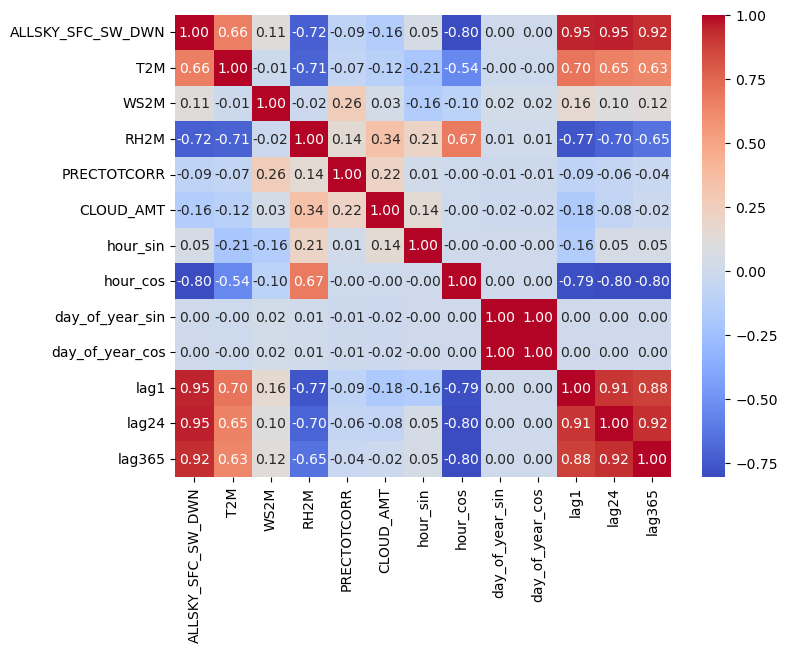

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix=df_hourly.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)


In [30]:
# standardize the continuous variables like T2M, WS2M, RH2M, PRECTOTCORR, CLOUD_AMT
from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
col_to_scale=['T2M', 'WS2M', 'RH2M','PRECTOTCORR', 'CLOUD_AMT']
df_hourly[col_to_scale]=scalar.fit_transform(df_hourly[col_to_scale])
df_hourly

,ALLSKY_SFC_SW_DWN,T2M,WS2M,RH2M,PRECTOTCORR,CLOUD_AMT,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,lag1,lag24,lag365
8760,0.0,-1.516432,1.108187,1.053128,1.891424,1.333689,0.000000,1.000000,0.017213,0.017213,0.0,0.0,0.0
8761,0.0,-1.496281,1.169174,1.059686,1.998673,1.333689,0.258819,0.965926,0.017213,0.017213,0.0,0.0,0.0
8762,0.0,-1.455980,1.016706,1.049597,1.938664,1.188204,0.500000,0.866025,0.017213,0.017213,0.0,0.0,0.0
8763,0.0,-1.377394,0.528809,1.057164,1.729274,1.333689,0.707107,0.707107,0.017213,0.017213,0.0,0.0,0.0
8764,0.0,-1.318958,-0.213202,1.080874,2.229769,1.313146,0.866025,0.500000,0.017213,0.017213,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105187,0.0,-1.500311,0.691441,0.897249,-0.184608,-1.199765,-0.965926,0.258819,0.508671,0.508671,0.0,0.0,0.0
105188,0.0,-1.611139,0.610125,1.049093,-0.184608,-1.251543,-0.866025,0.500000,0.508671,0.508671,0.0,0.0,0.0
105189,0.0,-1.713906,0.559302,1.146454,-0.184608,-1.303602,-0.707107,0.707107,0.508671,0.508671,0.0,0.0,0.0
105190,0.0,-1.784432,0.508480,1.152507,-0.184608,-1.355098,-0.500000,0.866025,0.508671,0.508671,0.0,0.0,0.0


In [31]:
Y_train=df_hourly['ALLSKY_SFC_SW_DWN'].to_frame()
df_hourly.drop(['ALLSKY_SFC_SW_DWN'],axis=1, inplace=True)
X_train=df_hourly

In [32]:
from sklearn.model_selection import train_test_split

X_train_split,X_test_split,Y_train_split,Y_test_split = train_test_split(X_train,Y_train,test_size=0.2,shuffle=False)

In [33]:
def Regression_report(report,df_ori,df_pred):
    mae=mean_absolute_error(df_ori,df_pred)
    mse = mean_squared_error(df_ori,df_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(df_ori,df_pred)
    error= mae*100/(df_ori.mean())
    print(f"Regression_report{report}\n")
    print(f"\nmae: {mae}\nmse: {mse}\nrmse: {rmse}\nr2: {r2}\n%error: {error} ")

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,make_scorer,fbeta_score,confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
linear_reg=LinearRegression()
linear_reg.fit(X_train,Y_train)
Y_lin_pred= linear_reg.predict(X_test_split)
Regression_report('linear_reg_test',Y_test_split,Y_lin_pred)

Regression_reportlinear_reg_test


mae: 38.0042248390375
mse: 2404.1135289916797
rmse: 49.031760410897746
r2: 0.9673300119282243
%error: ALLSKY_SFC_SW_DWN    19.742666
dtype: float64 


<Axes: >

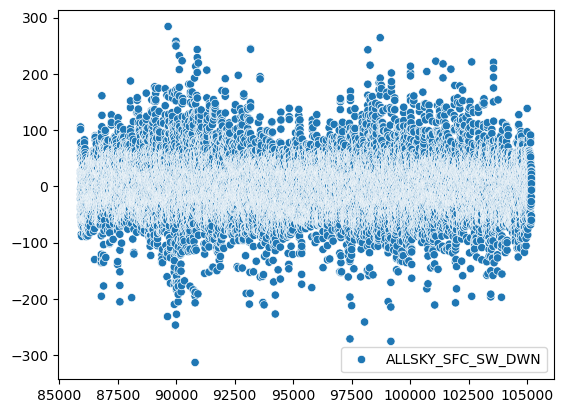

In [35]:
Resi=Y_test_split-Y_lin_pred
sns.scatterplot(Resi)

In [36]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
Param_grid={ 'alpha': [4900,4850] }
linear_regu = Ridge(fit_intercept= True)
cv_grid_search= GridSearchCV(linear_regu,n_jobs=-1,cv=10, scoring='neg_mean_absolute_error',param_grid=Param_grid)
cv_grid_search.fit(X_train_split,Y_train_split)
print('best_parameters',cv_grid_search.best_params_)
best_model=cv_grid_search.best_estimator_
Y_ridge_train_pred=best_model.predict(X_train_split)
Y_ridge_test_pred=best_model.predict(X_test_split)

coefficient=best_model.coef_
Intercept=best_model.intercept_
print(f'coefficient\n{coefficient}\n\n Intercept:{Intercept}')
Regression_report("Train_set",Y_train_split,Y_ridge_train_pred)

Regression_report("Test_set",Y_test_split,Y_ridge_test_pred)

best_parameters {'alpha': 4900}
coefficient
[ -2.52014305  -3.77485268   0.63963433  -1.32618823 -12.88539727
  38.78665414  -3.3510466   -0.08121512  -0.08121512   0.52239513
   0.31608218   0.17063885]

 Intercept:[-1.33349305]
Regression_reportTrain_set


mae: 38.409234956471764
mse: 2710.5672179549533
rmse: 52.06310803203122
r2: 0.9645536118483725
%error: ALLSKY_SFC_SW_DWN    19.294702
dtype: float64 
Regression_reportTest_set


mae: 37.10297671587186
mse: 2405.8842603108683
rmse: 49.04981407009478
r2: 0.9673059490999183
%error: ALLSKY_SFC_SW_DWN    19.27448
dtype: float64 


In [37]:
Param_grid={ 'alpha': [1.2,1,0.9] }
linear_lasso = Lasso(fit_intercept= True)
cv_grid_search= GridSearchCV(linear_lasso,n_jobs=-1,cv=10, scoring='neg_mean_absolute_error',param_grid=Param_grid)
cv_grid_search.fit(X_train_split,Y_train_split)
print('best_parameters',cv_grid_search.best_params_)
best_model=cv_grid_search.best_estimator_
Y_lasso_train_pred=best_model.predict(X_train_split)
Y_lasso_test_pred=best_model.predict(X_test_split)

coefficient=best_model.coef_
Intercept=best_model.intercept_
print(f'coefficient\n{coefficient}\n\n Intercept:{Intercept}')
Regression_report("Train_set",Y_train_split,Y_lasso_train_pred)

Regression_report("Test_set",Y_test_split,Y_lasso_test_pred)

best_parameters {'alpha': 1.2}
coefficient
[ -0.          -2.38481319  -0.          -0.41542623 -12.39451127
  43.21369517  -0.          -0.          -0.           0.53206786
   0.30877182   0.16767477]

 Intercept:[-1.22973343]
Regression_reportTrain_set


mae: 38.99519643826608
mse: 2704.3697984747237
rmse: 52.0035556330019
r2: 0.964634656190302
%error: ALLSKY_SFC_SW_DWN    19.589057
dtype: float64 
Regression_reportTest_set


mae: 37.833679164819365
mse: 2419.6973321485125
rmse: 49.19041910929925
r2: 0.967118240455244
%error: ALLSKY_SFC_SW_DWN    19.65407
dtype: float64 


In [56]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the Decision Tree model
param_grid_dt = {
    'max_depth': [5, 10, 15, None], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree Regressor
dt_regressor = DecisionTreeRegressor()

# Perform GridSearchCV
cv_grid_search_dt = GridSearchCV(dt_regressor, param_grid=param_grid_dt, n_jobs=-1, cv=10, scoring='neg_mean_absolute_error')
cv_grid_search_dt.fit(X_train_split, Y_train_split)

# Best parameters and model
print('Best Parameters for Decision Tree:', cv_grid_search_dt.best_params_)
best_model_dt = cv_grid_search_dt.best_estimator_

# Predictions
Y_dt_train_pred = best_model_dt.predict(X_train_split)
Y_dt_test_pred = best_model_dt.predict(X_test_split)

# Model coefficients (for decision trees, it's less intuitive than for linear models)
print(f'Best Decision Tree Model\n{best_model_dt}')

# Evaluate the model
Regression_report("Train_set", Y_train_split, Y_dt_train_pred)
Regression_report("Test_set", Y_test_split, Y_dt_test_pred)

Best Parameters for Decision Tree: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Decision Tree Model
DecisionTreeRegressor(max_depth=15, min_samples_leaf=4, min_samples_split=10)
Regression_reportTrain_set


mae: 7.221315020861454
mse: 262.9898167527389
rmse: 16.216960774224585
r2: 0.9965608529968217
%error: ALLSKY_SFC_SW_DWN    3.627594
dtype: float64 
Regression_reportTest_set


mae: 12.402960364206832
mse: 749.2557407428019
rmse: 27.37253624973035
r2: 0.9898182112377018
%error: ALLSKY_SFC_SW_DWN    6.443165
dtype: float64 


Desicion tree model yields a test error of ~6% which is acceptable for a solar resource assessment as this error dosent not change the viability of the project or dosent change the credit desicion/interest rate consideration.

Desicion tree explains feature importance, is more intutive and has better explainability to the senior management/stakeholders.

In [58]:
import shap

explainer = shap.Explainer(best_model_dt, X_train_split)
shap_values = explainer(X_test_split)

shap.summary_plot(shap_values, X_test_split)


ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 47.559998, while the model output was 41.757778. If this difference is acceptable you can set check_additivity=False to disable this check.

In [ ]:
dt_feature_importance= best_model_dt.feature_importances_
df_feature_importance = pd.DataFrame({'Feature': X_train_split.columns, 'Importance': dt_feature_importance})	
df_feature_importance

In [ ]:
Y_dt_pred_df= pd.DataFrame(Y_dt_test_pred, index=Y_test_split.index,columns=['Pred'])
dt_Residuals=pd.concat([Y_test_split,Y_dt_pred_df],axis=1)
# Y_dt_pred_df.index==Y_test_split.index
# Y_dt_pred_df
# Y_test_split
dt_Residuals['ALLSKY_SFC_SW_DWN'] = np.where(dt_Residuals['ALLSKY_SFC_SW_DWN'] == 0, np.nan, dt_Residuals['ALLSKY_SFC_SW_DWN'])

dt_Residuals['diff']=(dt_Residuals['ALLSKY_SFC_SW_DWN']-dt_Residuals['Pred'])/dt_Residuals['ALLSKY_SFC_SW_DWN']
dt_Residuals['diff'].describe()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize Random Forest Regressor with default parameters
rf_regressor = RandomForestRegressor(n_jobs=-1, random_state=42)

# Fit the model on training data
rf_regressor.fit(X_train_split, Y_train_split)

# Predictions on train and test set
Y_rf_train_pred = rf_regressor.predict(X_train_split)
Y_rf_test_pred = rf_regressor.predict(X_test_split)

# Model evaluation metrics
def regression_report(dataset_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Regression Report for {dataset_name}:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R2: {r2}")
    print(f"Percentage Error: {100 * mae / np.mean(y_true)}%")
    print("\n")

# Evaluate on train and test sets
regression_report("Train_set", Y_train_split, Y_rf_train_pred)
regression_report("Test_set", Y_test_split, Y_rf_test_pred)

# Optional: Print Feature Importances (to understand which features are important)
print("Feature Importances:")
for feature, importance in zip(X_train_split.columns, rf_regressor.feature_importances_):
    print(f"{feature}: {importance}")


#Randomforest model improved the model performance by only 1 percentage point. The arbitrage to swith model from descion tree to randomforrest is less as descion tree has better explainability. Also usage of blackbox models like deeplearning may further improve the model performance.

In [ ]:
#let us check the error in the prediction when actuals and 365 lag to see if we were not to use any models and use last years value are we better off?
lag_365_DF= pd.DataFrame(X_train['lag365'],index=X_train.index)
df_365= pd.concat([X_train['lag365'], Y_train],axis=1)
df_365['diff']=(df_365['lag365']-df_365['ALLSKY_SFC_SW_DWN'])

#Comparing with the prediction values
df_Y_dt_train_pred= pd.DataFrame(Y_dt_train_pred,columns=['Y_train_pred'])
df_pred_concat= pd.concat([Y_train_split.reset_index(drop=True),df_Y_dt_train_pred.reset_index(drop=True)], axis=1)
df_pred_concat['diff']=df_pred_concat['ALLSKY_SFC_SW_DWN']-df_pred_concat['Y_train_pred']


def compare(df):
    compare_list=[]
    for i in range(0,len(df)-366,365):
        window=df.iloc[i:i+365,]
        window1,window2,window_diff=sum(window.iloc[:,0]),sum(window.iloc[:,1]),sum(window.iloc[:,2])
        compare_list.append((window1,window2,window_diff))
        df_compare=pd.DataFrame(data=compare_list,columns=['actual','pred','diff'])
        
    return(df_compare)
    
lag_compare=compare(df_365)
model_compare=compare(df_pred_concat)
print(f"without model results\n{lag_compare.describe()}")
print(f"with model results\n {model_compare.describe()}")

In [64]:
import pickle

In [70]:
import pickle
pickle.dump(best_model_dt, open("Dt_model.pkl", "wb"))
print("Model retrained and saved.")

Model retrained and saved.


In [68]:
best_model_dt.

DecisionTreeRegressor(max_depth=15, min_samples_leaf=4, min_samples_split=10)